In [46]:
import jax
import jax.numpy as jnp
import flax.linen as nn
from functools import partial
import optax
import matplotlib.pyplot as plt
from jax.random import key
from jax.tree_util import keystr,tree_map_with_path,tree_map
import numpy as np
import tensorflow_datasets as tfds
from tqdm import tqdm

In [47]:
class FullyConnected(nn.Module):
    num_outputs : int

    @nn.compact
    def __call__(self,x):

        x = nn.Dense(features=128)(x)
        x = nn.relu(x)
        x = nn.Dense(features=64)(x)
        x = nn.relu(x)
        x = nn.Dense(features=self.num_outputs)(x)

        return x

In [48]:
@jax.jit
def svd_mutate_w(w,delta):
    u,s,vt = jnp.linalg.svd(w,full_matrices=False)

    singular_value_scale = (jnp.log(jnp.arange(start=1,stop=s.shape[0]+1))+1)*delta + 1
    s = s/singular_value_scale
    
    return u @ jnp.diag(s) @ vt

@jax.jit
def weight_rescale(w):
    mean = jnp.mean(w,axis=0)[None,:]
    norm = jnp.linalg.norm(w.reshape(-1,w.shape[-1]),axis=0)[None,:]
    return (w-mean)/(norm+1e-7)

@jax.jit
def weight_normalize(w):
    norm = jnp.linalg.norm(w.reshape(-1,w.shape[-1]),axis=0)[None,:]
    return w/(norm+1e-7)


In [49]:
@partial(jax.jit,static_argnums=3)
def get_loss_fn(params,x,y,apply_fn):
    prediction = apply_fn(params,x)
    loss = optax.losses.softmax_cross_entropy_with_integer_labels(logits=prediction,labels=y)
    return jnp.mean(loss)

@partial(jax.jit,static_argnums=3)
def get_acc_fn(params,x,y,apply_fn):
    prediction = apply_fn(params,x)
    return jnp.mean(prediction.argmax(-1)==y)

@partial(jax.grad,argnums=0,has_aux=True)
def get_grad_fn(params,x,y,apply_fn):
    loss = get_loss_fn(params,x,y,apply_fn)
    return loss, {"loss" : loss}

@partial(jax.jit,static_argnums=(4,5))
def step_fn(params,opt_params,x,y,apply_fn,optim_update_fn):

        grad,aux = get_grad_fn(params,x,y,apply_fn)

        updates,new_opt_params = optim_update_fn(grad,opt_params,params)
        new_params = optax.apply_updates(params,updates)

        return new_params,new_opt_params,aux

In [50]:
ds = tfds.load("german_credit_numeric",data_dir="./datasets")["train"].map(lambda x: (x["features"],x["label"]))
print(ds)
ds_train = ds.take(900).repeat(-1).shuffle(5000).batch(32).prefetch(32).as_numpy_iterator()
ds_test = ds.skip(900).repeat(-1).shuffle(5000).batch(100).prefetch(32).as_numpy_iterator()

<_MapDataset element_spec=(TensorSpec(shape=(24,), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


  0%|          | 0/1000 [00:00<?, ?it/s]

2024-11-14 23:10:30.621734: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-11-14 23:10:30.626555: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-11-14 23:10:30.631256: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. I

0.85999995


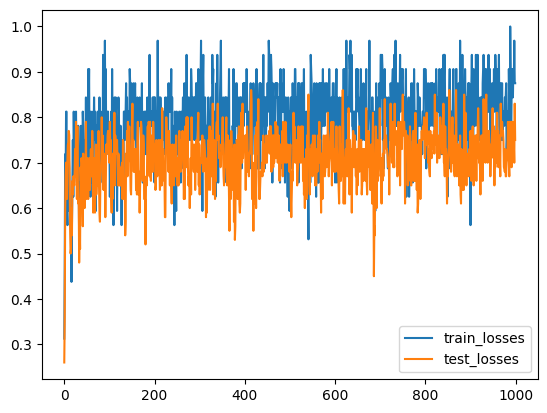

In [51]:
step = []
train_losses = []
test_losses = []
model = FullyConnected(2)
params = model.init(key(42),jnp.ones((1,24)))
optim = optax.adam(learning_rate=0.001)
opt_params = optim.init(params)

for i,(x_train,y_train),(x_test,y_test) in zip(tqdm(range(1000)),ds_train,ds_test):

    params,opt_params,aux = step_fn(params,opt_params,x_train,y_train,model.apply,optim.update)
    train_loss = get_acc_fn(params,x_train,y_train,model.apply)
    test_loss = get_acc_fn(params,x_test,y_test,model.apply)

    step.append(i)
    train_losses.append(np.asarray(train_loss))
    test_losses.append(np.asarray(test_loss))

print(max(test_losses))
plt.plot(step,train_losses,label="train_losses")
plt.plot(step,test_losses,label="test_losses")
plt.legend()

100%|██████████| 1000/1000 [00:01<00:00, 503.28it/s]

0.87


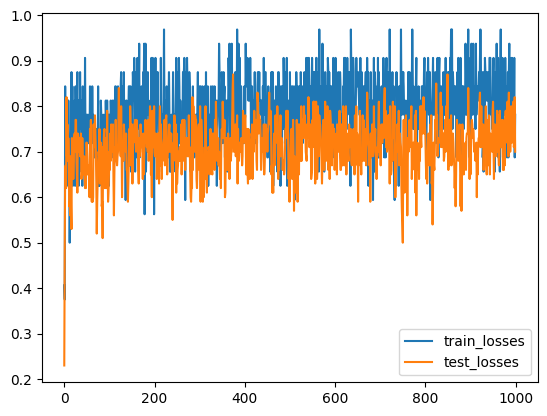

In [52]:
step = []
train_losses = []
test_losses = []
model = FullyConnected(2)
params = model.init(key(42),jnp.ones((1,24)))
wd_mask = tree_map_with_path(lambda s,_ : "Dense" in keystr(s) and "kernel" in keystr(s),params)
optim = optax.chain(optax.add_decayed_weights(weight_decay=0.005,mask=wd_mask),optax.adam(learning_rate=0.001))
opt_params = optim.init(params)

for i,(x_train,y_train),(x_test,y_test) in zip(tqdm(range(1000)),ds_train,ds_test):

    params,opt_params,aux = step_fn(params,opt_params,x_train,y_train,model.apply,optim.update)
    train_loss = get_acc_fn(params,x_train,y_train,model.apply)
    test_loss = get_acc_fn(params,x_test,y_test,model.apply)

    step.append(i)
    train_losses.append(np.asarray(train_loss))
    test_losses.append(np.asarray(test_loss))

print(max(test_losses))
plt.plot(step,train_losses,label="train_losses")
plt.plot(step,test_losses,label="test_losses")
plt.legend()

100%|██████████| 1000/1000 [00:03<00:00, 318.15it/s]

0.87


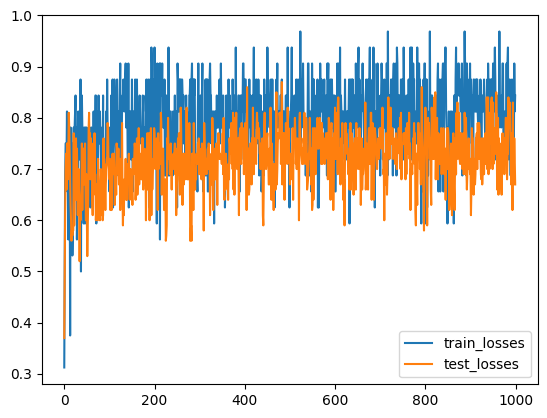

In [53]:
step = []
train_losses = []
test_losses = []
model = FullyConnected(2)
params = model.init(key(42),jnp.ones((1,24)))
optim = optax.adam(learning_rate=0.001)

norm_fn = lambda tree : jax.jit(lambda w : tree_map_with_path(lambda s,x : svd_mutate_w(x,0.01) if "Dense" in keystr(s) and "kernel" in keystr(s) else x,w))(tree)
opt_params = optim.init(params)

for i,(x_train,y_train),(x_test,y_test) in zip(tqdm(range(1000)),ds_train,ds_test):

    params,opt_params,aux = step_fn(params,opt_params,x_train,y_train,model.apply,optim.update)
    train_loss = get_acc_fn(params,x_train,y_train,model.apply)
    test_loss = get_acc_fn(params,x_test,y_test,model.apply)
    
    if i%50 == 0:
        params = norm_fn(params)

    step.append(i)
    train_losses.append(np.asarray(train_loss))
    test_losses.append(np.asarray(test_loss))

print(max(test_losses))
plt.plot(step,train_losses,label="train_losses")
plt.plot(step,test_losses,label="test_losses")
plt.legend()